In [1]:
# Libraries
import pandas as pd
import numpy as np

# Imports for model building
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout

# Imports for image transformations
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomTranslation

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Importing Keras utility for image dataset loading
from keras.utils import image_dataset_from_directory

# Reporting
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Imports for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Variables
dataset_folder = r'C:\Users\Thoma\Downloads\Python\dataset' # We stored the masked files in this dataset folder
class_normal = 'normal'
class_lung_opacity = 'lung_opacity'
class_viral_pneumonia = 'viral_pneumonia'
class_covid = 'covid'

### First try with Transfer Learning

##### Dataset loading and preprocessing

In [3]:
# For testing purposes, we try not loading all classes
normal_covid_classes = [class_normal, class_covid]
batch_size = 16 # Rather small for fine grained learning rate

# First load the whole dataset with implicit resizing for VGG16
train_ds = image_dataset_from_directory(
    dataset_folder,
# don't give class names to the loader, so all classes are loaded
#    class_names = normal_covid_classes,
    validation_split=0.2,       # Fraction of the data used for validation
    subset="training",          # Load the training data
    seed=42,                    # Seed for data splitting
    batch_size=batch_size,
    image_size=(224,224)        # Resize for compatibility with VGG16
)

val_ds = image_dataset_from_directory(
    dataset_folder,
# don't give class names to the loader, so all classes are loaded
#    class_names = normal_covid_classes,
    validation_split=0.2,       # Fraction of the data used for validation
    subset="validation",        # Load the validation data
    seed=42,
    batch_size=batch_size,
    image_size=(224,224)        # automatic resizing to the CNN input shape
)

# Check, which class names found (should be our 4 (or less for trials)) and save it for later use
class_names = train_ds.class_names.copy()
print(class_names)

# Adding optimization: caching and preloading
# This caused some errors, when only part of it is read, maybe switch it off
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.
['covid', 'lung_opacity', 'normal', 'viral_pneumonia']


In [4]:
# Number of batches in the training dataset
print("Number of batch in train_ds:", train_ds.cardinality().numpy())

# Number of batches in the validation dataset
print("Number of batch in val_ds:", val_ds.cardinality().numpy())

# Let's check compatible input format for VGG16
for image, _ in train_ds.take(1):
    print(image.shape)
    break

Number of batch in train_ds: 1059
Number of batch in val_ds: 265
(16, 224, 224, 3)


In [5]:
# We have imbalanced data, hence let's calculate class_weights to give it the model
from collections import Counter

# Count occurrences of each class
class_counts = Counter()
total_count = 0
for images, labels in train_ds:
    for label in labels.numpy():  # Convert tensor to numpy
        class_counts[label] += 1
        total_count += 1

# Convert label indices to class names
class_counts_named = {class_names[idx]: count for idx, count in class_counts.items()}
print("Class Counts:", class_counts_named)

class_weights_dict = { class_label: total_count / (len(class_counts) * class_counts[class_label])
                 for class_label, class_count in class_counts.items() }
print('Class Weights:', class_weights_dict)


Class Counts: {'lung_opacity': 4847, 'normal': 8134, 'viral_pneumonia': 1048, 'covid': 2903}
Class Weights: {np.int32(1): 0.8733237053847741, np.int32(2): 0.5204081632653061, np.int32(3): 4.03912213740458, np.int32(0): 1.4581467447468137}


In [6]:
# Preprocessing for pretrained models in the same way
# the preprocessor comes with the pretrained model library
from tensorflow.keras.applications.vgg16 import preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

#### Try with VGG16 (imagenet pretrained)

In [7]:
# Imports for using a pre-trained model
from tensorflow.keras.applications.vgg16 import VGG16

# VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Freeze the layers of VGG16
base_model.trainable = False

# Model creation using the Functional API
inputs = Input(shape=(224, 224, 3))

# Apply augmentations
#x = RandomRotation(0.1)(inputs)
#x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x)
#x = RandomZoom(0.1)(x)
#x = RandomFlip("horizontal")(x)

# Build the model
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

vgg16 = Model(inputs=inputs, outputs=outputs)

In [8]:
# Applied Callbacks
early_stopping = EarlyStopping(
                                patience=3, # Wait for 5 epochs before applying
                                min_delta=0.01, # If the loss function doesn't change by 1% after 3 epochs, either up or down, we stop
                                verbose=1, # Display the epoch at which training stops
                                mode='min',
                                monitor='val_loss')

# A learning rate reduction callback to reduce the learning rate when the validation loss stagnates
reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # If val_loss stagnates for 3 consecutive epochs based on the min_delta value
                                    min_delta=0.01,
                                    factor=0.1,  # Reduce the learning rate by a factor of 0.1
                                    cooldown=3,  # Wait 3 epochs before retrying
                                    verbose=1)

In [9]:
# Compile with first idea of appropriate parameters
vgg16.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print how it looks like
vgg16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,766,852 (60.15 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# First training just on 10 batches (otherwise this would run endlessly on my machine)
history_model = vgg16.fit(train_ds,
                          epochs=10,
                          validation_data=val_ds,
                          class_weight=class_weights_dict,
                          callbacks=[early_stopping, reduce_learning_rate])

# Save the model for potential later use
save_name = 'vgg16_' + str(len(class_names)) + '-classes.keras'
vgg16.save('vgg16.keras')

Epoch 1/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 573s 540ms/step - accuracy: 0.6606 - loss: 0.9448 - val_accuracy: 0.7713 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 2/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 556s 525ms/step - accuracy: 0.7639 - loss: 0.5115 - val_accuracy: 0.7883 - val_loss: 0.5318 - learning_rate: 0.0010
Epoch 3/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 556s 525ms/step - accuracy: 0.7815 - loss: 0.4998 - val_accuracy: 0.8042 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 4/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 553s 522ms/step - accuracy: 0.7999 - loss: 0.4439 - val_accuracy: 0.8146 - val_loss: 0.4811 - learning_rate: 0.0010
Epoch 5/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 571s 539ms/step - accuracy: 0.8017 - loss: 0.4209 - val_accuracy: 0.8169 - val_loss: 0.4733 - learning_rate: 0.0010
Epoch 6/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 632s 596ms/step - accuracy: 0.8134 - loss: 0.4043 - val_accuracy: 0.8370 - val_loss: 0.4224 - learning_rate: 0.0010
Epoch 7/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 631s 596ms

##### Evalution

In [11]:
def plot_learning_curve(history_model):
    plt.figure(figsize=(12,4))

    plt.subplot(121)
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('Model loss by epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')

    plt.subplot(122)
    plt.plot(history_model.history['accuracy'])
    plt.plot(history_model.history['val_accuracy'])
    plt.title('Model accuracy by epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')
    plt.show()

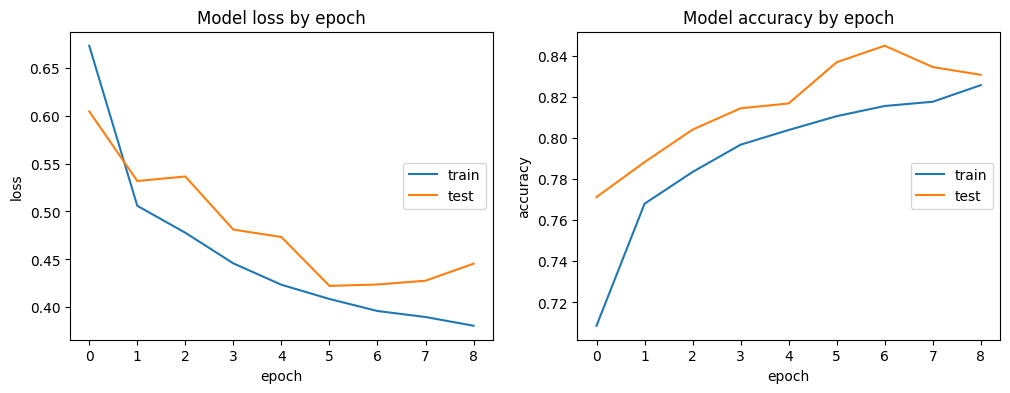

In [12]:
plot_learning_curve(history_model)

> We can see, that our model accuracy stagnates at appr. 70%
> It seems, that we cannot improve here much.

In [13]:
# Get true labels and predictions from the test dataset
def get_predictions_and_labels(model, dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:

        preds = model.predict(images, verbose=0)  # Get the model's predictions
        pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)

        true_labels.extend(labels.numpy())  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

# Print a report with classification_report and heatmap confusion_matrix
def report_preds(y_true, y_pred):
    # Print the classification report (precision, recall, F1-score)
    print(classification_report_imbalanced(y_true, y_pred, target_names=class_names))

    # Show also the non-normalized crosstab
    #display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted']))
    ct = pd.crosstab(y_true, y_pred, rownames=['True'],colnames=['Predicted'])
    column_mapping = {index: class_name for index, class_name in enumerate(class_names)}
    ct = ct.rename(columns=column_mapping)
    ct.index = class_names
    display(ct)

    # Display the confusion matrix
    plt.figure(figsize=(4, 4))  # Create a large figure for the confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
    sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=np.arange(0.5,len(class_names)+0.5,1), labels=class_names, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(0.5,len(class_names)+0.5,1), labels=class_names, rotation=45, ha='right')
    plt.show()

In [14]:
y_true, y_pred = get_predictions_and_labels(vgg16, val_ds)

                       pre       rec       spe        f1       geo       iba       sup

          covid       0.73      0.68      0.95      0.71      0.80      0.63       713
   lung_opacity       0.89      0.73      0.97      0.80      0.84      0.69      1165
         normal       0.84      0.92      0.84      0.88      0.88      0.78      2058
viral_pneumonia       0.77      0.97      0.98      0.86      0.98      0.95       297

    avg / total       0.83      0.83      0.90      0.83      0.86      0.74      4233



Predicted,covid,lung_opacity,normal,viral_pneumonia
covid,485,63,160,5
lung_opacity,115,848,188,14
normal,60,37,1895,66
viral_pneumonia,0,0,8,289


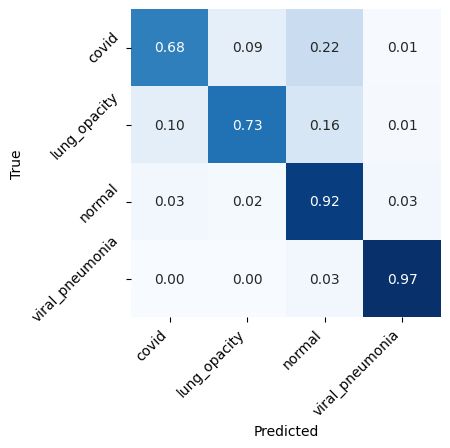

In [15]:
report_preds(y_true, y_pred)

# Conclusion: TBD